In [21]:
# Setup
import sys
import numpy as np
# import tensorflow as tf
import Utils.PokemonUtils as pkmnUtils
from matplotlib import pyplot as plt
import importlib

utils = pkmnUtils.PokemonUtils(rel_loc="")

# Only run if split file has not already been generated
if False:
    utils.loadAllGIFs()
    
utils.localLoadAllGifs("Data/SplitsV2.npz")
x_train, x_val, x_test, y_train, y_val, y_test = utils.getSplits()

USE_GPU = False
if USE_GPU:
    device = '/device:GPU:0'
else:
    device = '/cpu:0'
    
def oneHot(y, cols=None):
    if (cols < 1):
        cols = np.max(y)
    n = y.shape[0]
    z = np.zeros((n, cols))
    z[np.arange(n), (y-1)] = 1
    return z

x_train: (6010, 128, 128, 4)
x_val:   (1510, 128, 128, 4)
x_test:  (1880, 128, 128, 4)
y_train: (6010,)
y_val:   (1510,)
y_test:  (1880,)


In [48]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [152]:
from matplotlib.colors import rgb_to_hsv

def color_histogram_hsv(im, nbin=10, xmin=0, xmax=255, normalized=True):
  """
  Compute color histogram for an image using hue.

  Inputs:
  - im: H x W x C array of pixel data for an RGB image.
  - nbin: Number of histogram bins. (default: 10)
  - xmin: Minimum pixel value (default: 0)
  - xmax: Maximum pixel value (default: 255)
  - normalized: Whether to normalize the histogram (default: True)

  Returns:
    1D vector of length nbin giving the color histogram over the hue of the
    input image.
  """
  ndim = im.ndim
  bins = np.linspace(xmin, xmax, nbin+1)

  # Extract only opaque pixels
  im2 = im.reshape(-1,4)
  im2 = im2[im2[:,3]>0]

  hsv = rgb_to_hsv(im2[:,0:3]/xmax) * xmax
  imhist, bin_edges = np.histogram(hsv[:,0], bins=bins, density=normalized)
  imhist = imhist * np.diff(bin_edges)

  # return histogram
  return imhist

In [153]:
def ims_to_hists(ims, nbin=10):
    N = ims.shape[0]
    result = np.empty((N, nbin))
    for n in range(N):
        result[n,:] = color_histogram_hsv(x_train[n], nbin=nbin)
    return result

In [218]:
nbin = 6
x_train_hist = ims_to_hists(x_train, nbin)
print("Done!")
x_val_hist   = ims_to_hists(x_val, nbin)
print("Done!")
x_test_hist  = ims_to_hists(x_test, nbin)
print("Done!")

Done!
Done!
Done!


In [219]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout
from keras import regularizers

def getInitialModel(dim, reg=0, drop=0.5):
    print("Model params: drop =", drop, ", reg =", reg)
    model = Sequential([
#             Dense(128, kernel_regularizer=regularizers.l2(reg), input_dim=dim),
#             Activation("relu"),
#             Dropout(drop),
            Dense(64, kernel_regularizer=regularizers.l2(reg), input_dim=dim),
            Activation("relu"),
            Dropout(drop),
            Dense(18, kernel_regularizer=regularizers.l2(reg)),
            Activation("softmax")
        ])
    return model

In [220]:
model = getInitialModel(nbin, reg=10**-2, drop=0)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model params: drop = 0 , reg = 0.01


In [221]:
# Training
batch_size = 64
history = model.fit(
    x_train_hist, 
    oneHot(y_train, 18),
    batch_size=batch_size,
    epochs=30,
    verbose=1,
    validation_data=(x_val_hist, oneHot(y_val, 18)),
)
model.save("./Models/colorhist_1.hdf5")

Train on 6010 samples, validate on 1510 samples
Epoch 1/30
6010/6010 [==============================] - 7s 1ms/step - loss: 3.0762 - acc: 0.1661 - val_loss: 3.0051 - val_acc: 0.1192
Epoch 2/30
6010/6010 [==============================] - 0s 69us/step - loss: 2.8296 - acc: 0.1745 - val_loss: 2.9301 - val_acc: 0.1517
Epoch 3/30
6010/6010 [==============================] - 0s 57us/step - loss: 2.7462 - acc: 0.2206 - val_loss: 2.9200 - val_acc: 0.1517
Epoch 4/30
6010/6010 [==============================] - 0s 63us/step - loss: 2.7117 - acc: 0.2223 - val_loss: 2.9190 - val_acc: 0.1457
Epoch 5/30
6010/6010 [==============================] - 0s 59us/step - loss: 2.6949 - acc: 0.2295 - val_loss: 2.9270 - val_acc: 0.1497
Epoch 6/30
6010/6010 [==============================] - 0s 60us/step - loss: 2.6856 - acc: 0.2273 - val_loss: 2.9323 - val_acc: 0.1371
Epoch 7/30
6010/6010 [==============================] - 0s 60us/step - loss: 2.6794 - acc: 0.2300 - val_loss: 2.9366 - val_acc: 0.1450
Epoch 8/

In [169]:
# Test levels of regularization
drops = []
regs = []
val_accs = []
train_accs = []

iters = 10
epochs = 10

for i in range(iters):
    print("Iteration", i+1)
    z = np.random.uniform(-2,-.1)  # np.random.uniform(-4,-1)
    d = np.random.uniform(-10,-5)  # np.random.uniform(-0.3,-.001)
    reg = 10**z
    drop = 0 #10**d
    model = getInitialModel(nbin, reg=reg, drop=drop)
    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    batch_size = 64
    history = model.fit(
        x_train_hist, 
        oneHot(y_train, 18),
        batch_size=batch_size,
        epochs=epochs,
        verbose=1,
        validation_data=(x_val_hist, oneHot(y_val, 18)),
    )
    drops.append(drop)
    regs.append(reg)
    val_accs.append(history.history['val_acc'])
    train_accs.append(history.history['acc'])

Iteration 1
Model params: drop = 0 , reg = 0.20531887016709935
Train on 6010 samples, validate on 1510 samples
Epoch 1/10
6010/6010 [==============================] - 6s 1ms/step - loss: 8.5272 - acc: 0.1468 - val_loss: 5.8983 - val_acc: 0.1325
Epoch 2/10
6010/6010 [==============================] - 0s 54us/step - loss: 4.6100 - acc: 0.1444 - val_loss: 3.7288 - val_acc: 0.1258
Epoch 3/10
6010/6010 [==============================] - 0s 55us/step - loss: 3.2994 - acc: 0.1431 - val_loss: 3.0502 - val_acc: 0.1258
Epoch 4/10
6010/6010 [==============================] - 0s 57us/step - loss: 2.9062 - acc: 0.1431 - val_loss: 2.8657 - val_acc: 0.1258
Epoch 5/10
6010/6010 [==============================] - 0s 58us/step - loss: 2.7984 - acc: 0.1431 - val_loss: 2.8204 - val_acc: 0.1258
Epoch 6/10
6010/6010 [==============================] - 0s 63us/step - loss: 2.7665 - acc: 0.1431 - val_loss: 2.8069 - val_acc: 0.1258
Epoch 7/10
6010/6010 [==============================] - 0s 61us/step - loss: 2.7

Epoch 7/10
6010/6010 [==============================] - 0s 69us/step - loss: 2.7569 - acc: 0.1431 - val_loss: 2.8030 - val_acc: 0.1258
Epoch 8/10
6010/6010 [==============================] - 0s 60us/step - loss: 2.7474 - acc: 0.1431 - val_loss: 2.7999 - val_acc: 0.1258
Epoch 9/10
6010/6010 [==============================] - 0s 72us/step - loss: 2.7404 - acc: 0.1431 - val_loss: 2.7979 - val_acc: 0.1258
Epoch 10/10
6010/6010 [==============================] - 0s 76us/step - loss: 2.7348 - acc: 0.1431 - val_loss: 2.7950 - val_acc: 0.1258
Iteration 7
Model params: drop = 0 , reg = 0.03561547059139337
Train on 6010 samples, validate on 1510 samples
Epoch 1/10
6010/6010 [==============================] - 7s 1ms/step - loss: 3.8869 - acc: 0.1283 - val_loss: 3.4098 - val_acc: 0.1464
Epoch 2/10
6010/6010 [==============================] - 0s 74us/step - loss: 3.1442 - acc: 0.1557 - val_loss: 3.0007 - val_acc: 0.1258
Epoch 3/10
6010/6010 [==============================] - 0s 62us/step - loss: 2.

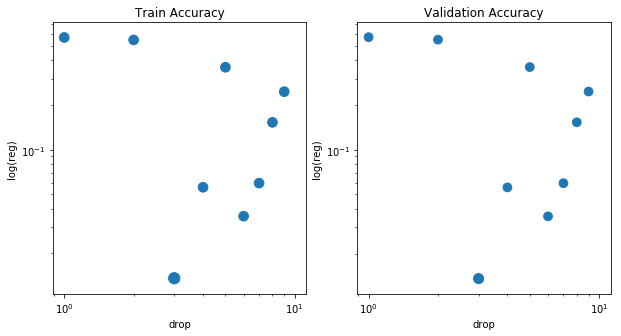

In [170]:
fig = plt.figure(figsize=(10,5))
gs = gridspec.GridSpec(1,2)

for i in range(2):
    t = None
    accs = None
    if i == 0:
        t = "Train"
        accs = train_accs
    else:
        t = "Validation"
        accs = val_accs
        
    ax = plt.subplot(gs[i])
    ax.set_title(t + " Accuracy")
    ax.set_xlabel("drop")
    ax.set_xscale('log')
    ax.set_ylabel("log(reg)")
    ax.set_yscale('log')
    ax.scatter(np.arange(10), np.array(regs), s=(np.array(accs)[:,epochs-1]-.05)*1e3)
plt.show()

In [68]:
# Get secondary typing 
y_train_2, y_val_2, y_test_2 = utils.getSecondaryTypeLabels()

y_train_2: (6010,)
y_val_2:   (1510,)
y_test_2:  (1880,)


In [191]:
pred_train = model.predict(x_train_hist)
print('Done!')
pred_val = model.predict(x_val_hist)
print('Done!')

Done!
Done!


Train predictions


/home/shared/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


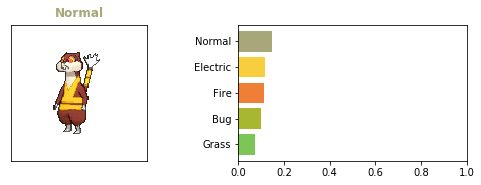

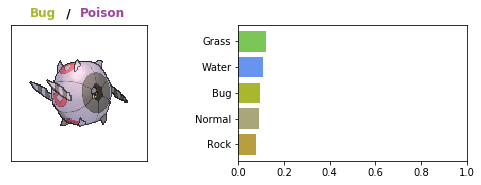

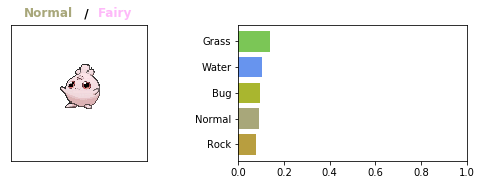

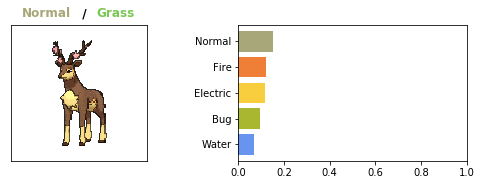

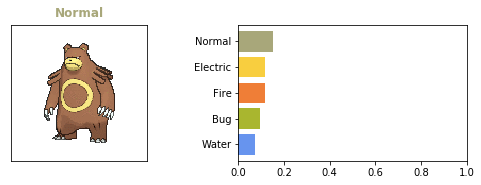

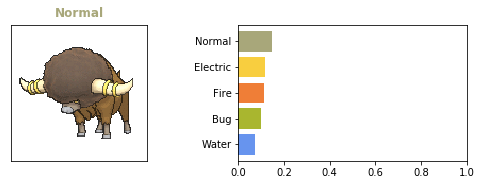

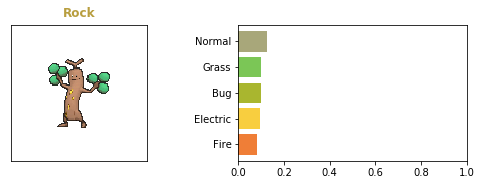

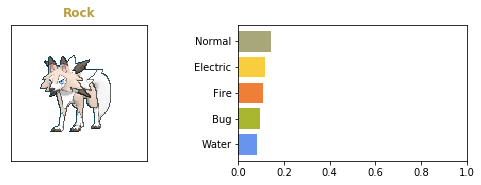

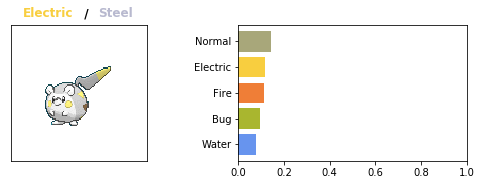

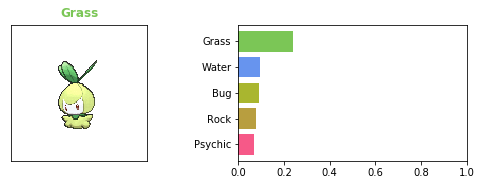

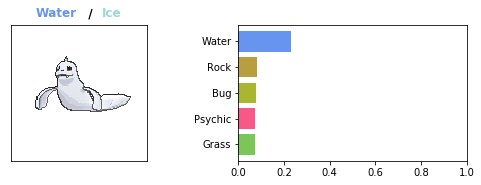

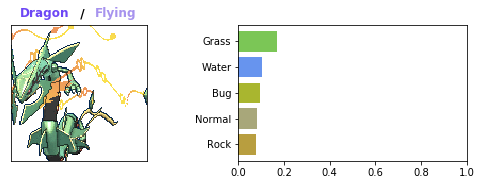

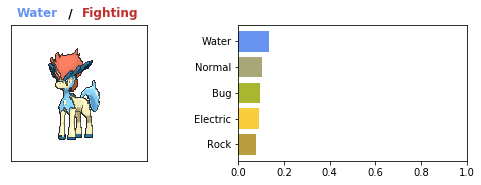

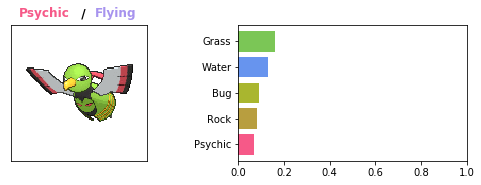

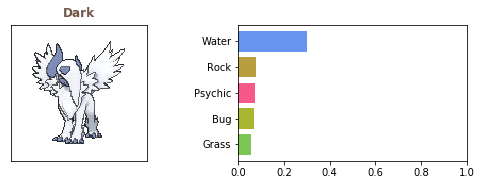

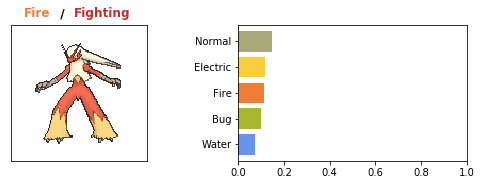

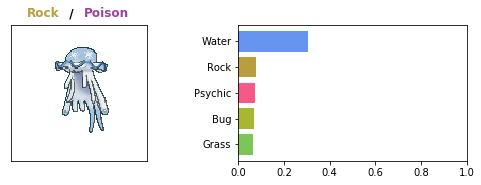

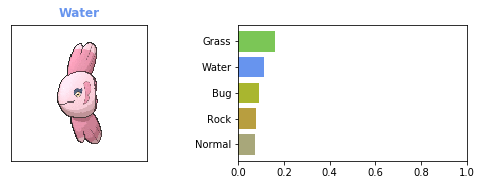

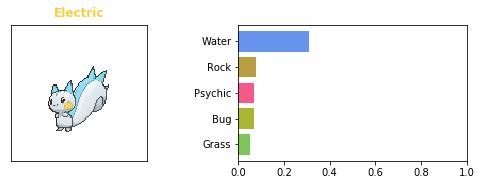

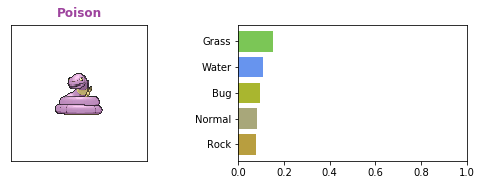

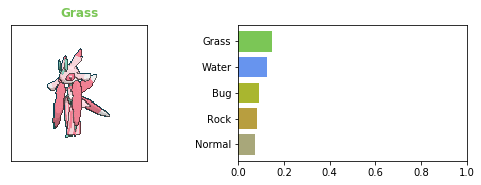

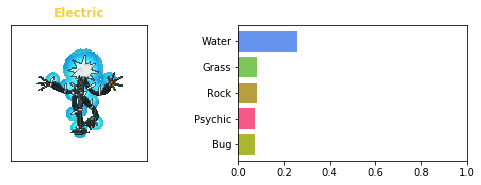

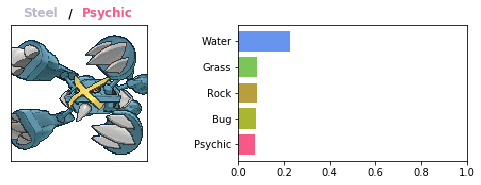

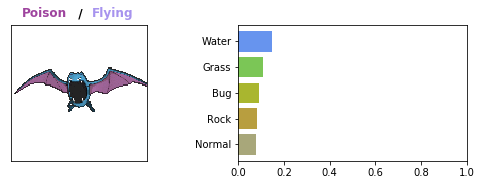

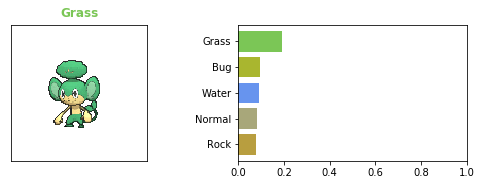

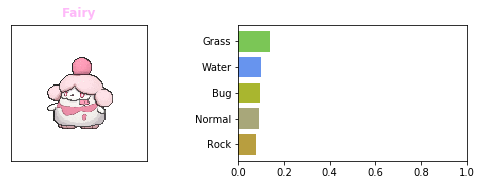

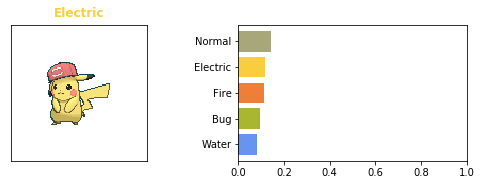

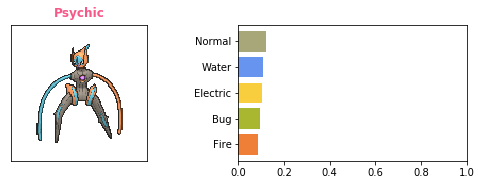

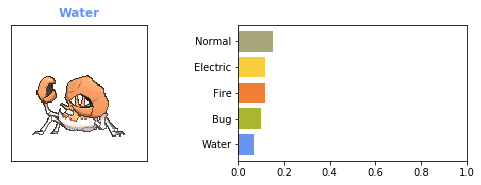

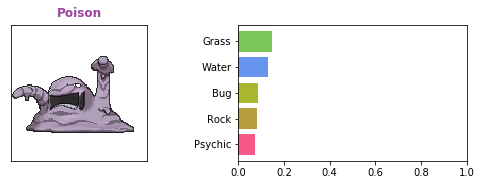

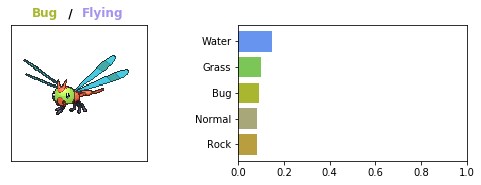

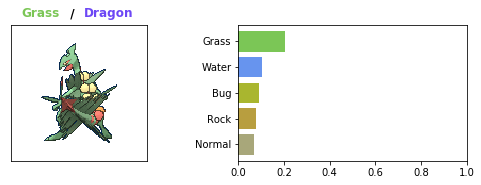

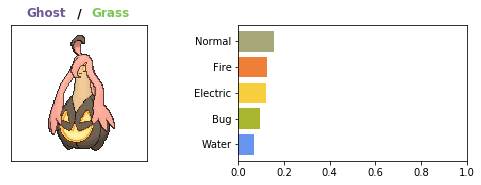

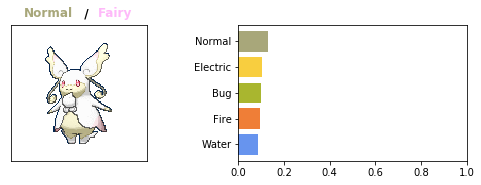

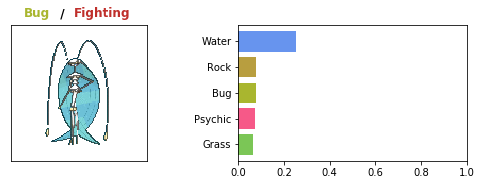

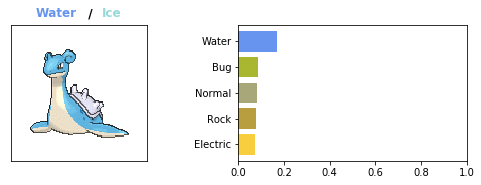

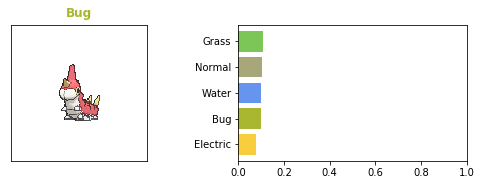

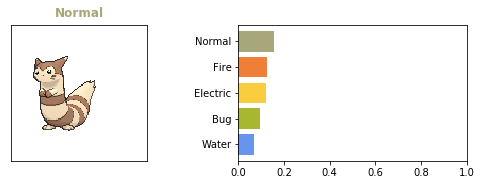

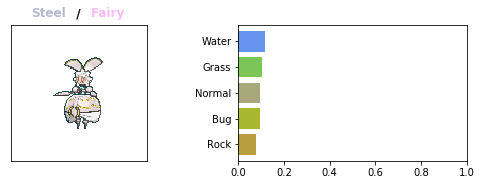

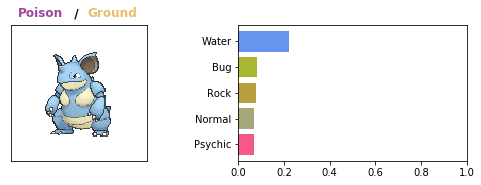

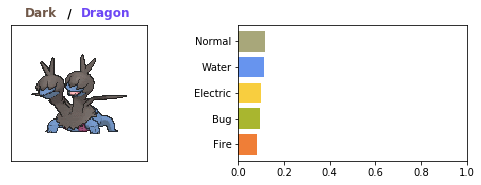

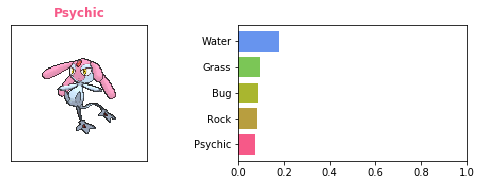

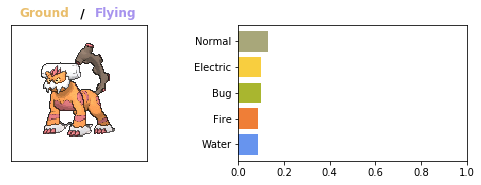

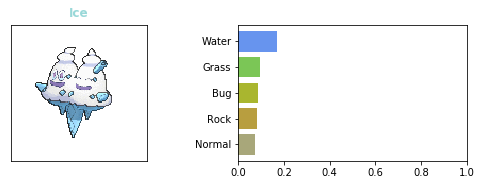

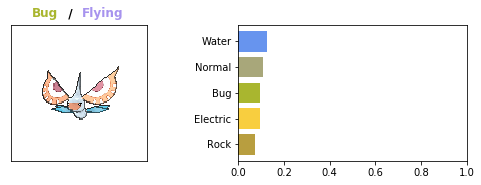

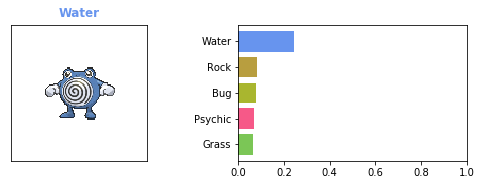

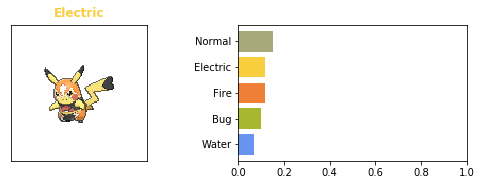

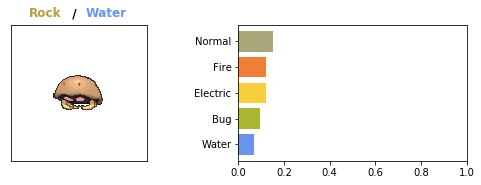

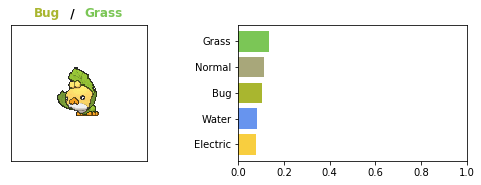

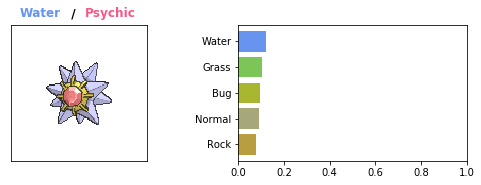

In [192]:
start = 100  # start index
num = 50    # number of images to display
step = 10  # number of frames / pokemon animation

print("Train predictions")
pp.plotPredictions(x_train[start*step:(start+num)*step:step],
                   y_train[start*step:(start+num)*step:step],
                   pred_train[start*step:(start+num)*step:step], k=5, y2=y_train_2[start*step:(start+num)*step:step])

Train predictions


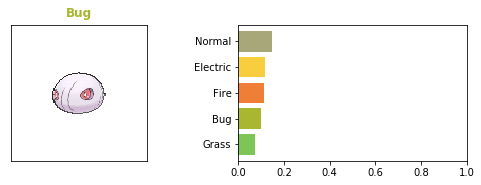

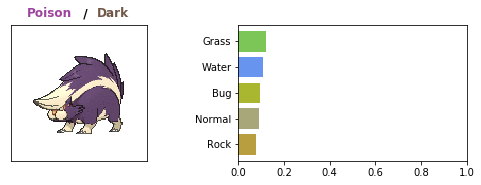

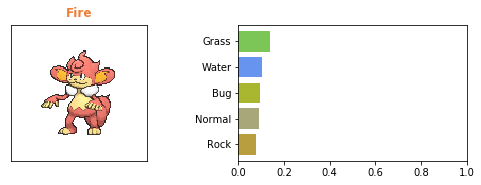

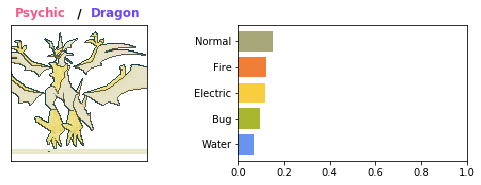

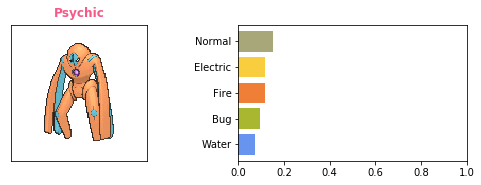

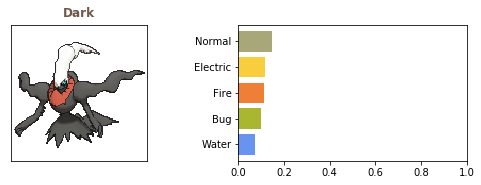

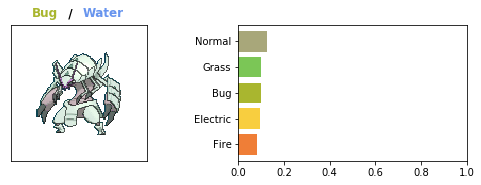

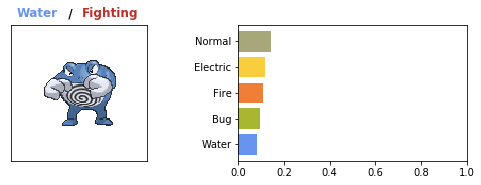

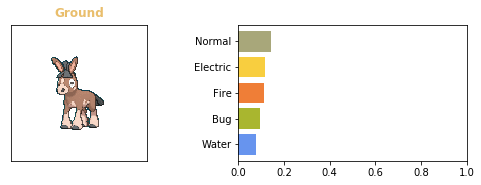

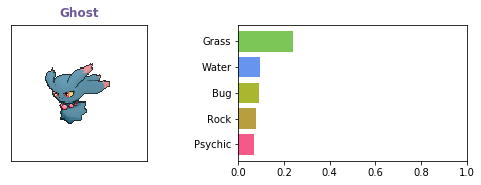

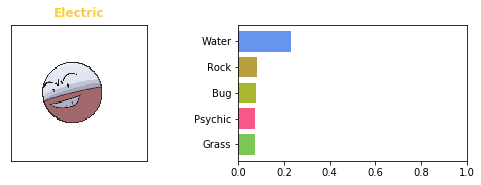

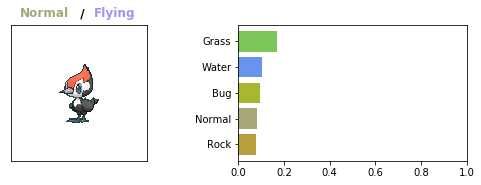

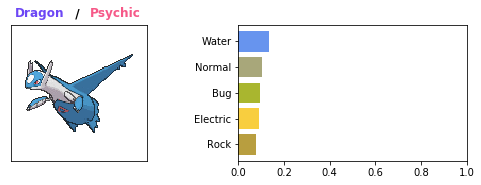

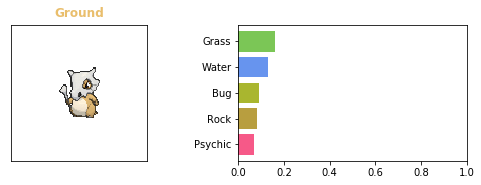

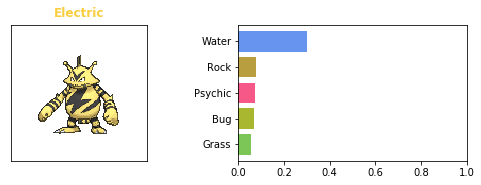

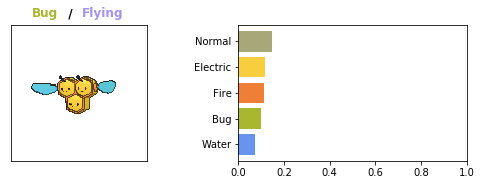

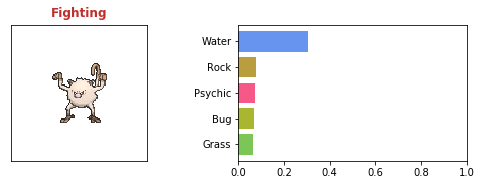

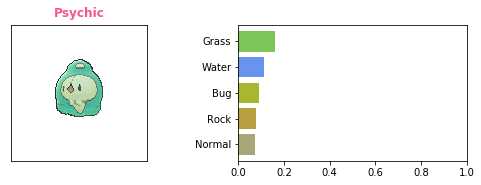

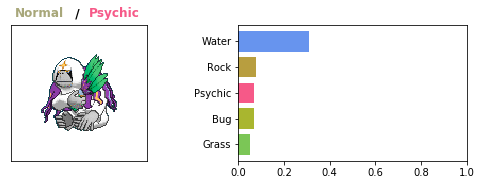

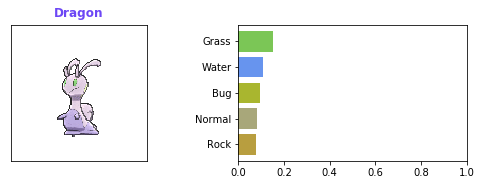

In [193]:
start = 100  # start index
num = 20    # number of images to display
step = 10  # number of frames / pokemon animation

print("Train predictions")
pp.plotPredictions(x_val[start*step:(start+num)*step:step],
                   y_val[start*step:(start+num)*step:step],
                   pred_val[start*step:(start+num)*step:step], k=5, y2=y_val_2[start*step:(start+num)*step:step])

[0.84701493 0.14676617 0.         0.         0.         0.00186567
 0.00124378 0.         0.00310945 0.        ]


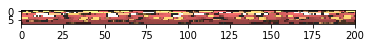

In [144]:
# Demo of how histogramming works

im = x_train[0]
nbin = 10
xmin=0
xmax=255
normalized=True
ndim = im.ndim
bins = np.linspace(xmin, xmax, nbin+1)

im2 = im.reshape(-1,4)
im2 = im2[im2[:,3]>0]
im3 = im2.reshape(8,-1,4)  # happened to be divisible by 8
plt.imshow(im3)

hsv = rgb_to_hsv(im[:,:,0:3]/xmax) * xmax
imhist, bin_edges = np.histogram(hsv[:,:,0][im[:,:,3]>0], bins=bins, density=normalized)
imhist = imhist * np.diff(bin_edges)

print(imhist)